In [1]:
import pathlib
import pint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import IPython.display

# convert units
ureg = pint.UnitRegistry()

# The importance of volume-conservative trend estimates in sea-level rise estimates

An important question in the analysis of global sea level is whether there is a recent acceleration. Recent studies [show](https://www.pnas.org/content/pnas/early/2018/02/06/1717312115.full.pdf) that there is a recent acceleration which could result in a [65cm](https://www.pnas.org/content/pnas/early/2018/02/06/1717312115.full.pdf) sea level at the end of the century. 

Here we analyse the sea-level before and during the satellite era. This is a followup on the [discussion](http://www.jcronline.org/doi/abs/10.2112/JCOASTRES-11A-00024.1?=) of how to deal with trend analysis in sea-level rise estimates. One point made in that discussion is that it is important to make sure that trends match up. Or as we put it "make sure that the trend estimates for connecting periods also have a connecting sea level". When comparing different era's, there should be no loss of mass.  

As an example we will use one of the most recent reconstructions made by [Jevrejeva 2014](http://dx.doi.org/10.1016/j.gloplacha.2013.12.004). One of the major advancements in that paper is that it uses the virtual station methods, that allows to correct for the known skewed spatial distributions of tide gauges, which in combination with the non-uniform sea-level fingerprints is important for creating an accurate reconstruction. 

Here we show failing to "connect the dots", or making non volume-conservative trend estimates can result in completely different conclusions about acceleration in the satellite era. 


In [2]:
# take the data of Jevrejeva 2014
f = pathlib.Path('~/src/sealevel/data/psmsl/gslGPChange2014.txt').expanduser()
columns = ['time', 'gsl_rate [mm]', 'gsl_rate_error [mm]', 'gsl [mm]', 'gsl_error [mm]']
# Read the data, % is used as a comment
jevrejeva_df = pd.read_csv(f, sep='\t', names=columns, comment='%')
jevrejeva_df = jevrejeva_df.set_index('time')

# Add other reconstructions later. 

reconstructions = {
    'jevrejeva': jevrejeva_df
}



In [3]:
reconstruction = 'jevrejeva'
df = reconstructions[reconstruction]


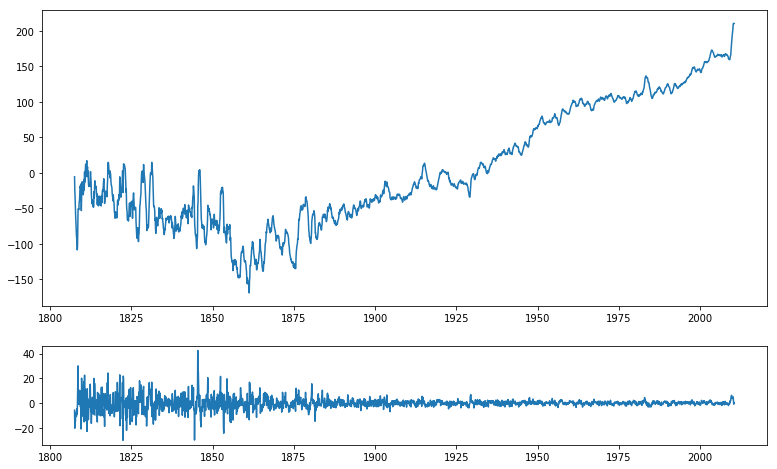

In [4]:
# tide gauges with higher sea-level rise deliver data earlier, hence the peak at the end of the series
# Jevrejeva et. al. leave out data after 2009
# In the paper the peak at the end is hard to see because it is plotted over the black axis
fig, axes = plt.subplots(2, 1, figsize=(13, 8), gridspec_kw=dict(height_ratios=(3, 1)))
axes[0].plot(df.index, df['gsl [mm]'])
axes[1].plot(df.index, df['gsl_rate [mm]'])

In [5]:
# let's define a statistical model. I think she uses AR1
def linear_model(df, start=None, end=None, with_acceleration=False, with_ar=True, with_break=False, hasconst=None):
    if start and end:
        selected = df[np.logical_and(df.index >= start, df.index < end)] 
    else:
        selected = df
    y = selected['gsl [mm]']
    X = np.c_[
        selected.index - 1970
    ]
    names = ['Trend']
    if with_break:
        X = np.c_[
            X,
            (selected.index.values > 1993) * (selected.index.values - 1993)
        ]
        names += ['Extra trend >= 1993']
    if with_acceleration:
        X = np.c_[
            X, 
            (selected.index - 1970)**2
        ]
        names += ['Acceleration']
    if not hasconst:
        X = sm.add_constant(X)
        names = ['Constant'] + names
    if with_ar:
        model = sm.GLSAR(y, X, missing='drop', rho=1, hasconst=hasconst)
    else:
        model = sm.OLS(y, X, missing='drop', hasconst=hasconst)
    fit = model.fit(cov_type='HC0')
    return fit, names    
    

In [6]:
model, names = linear_model(df)

In [7]:
# create a model before and after 1993
# these are the parameters I think Jevrejeva uses. 
# There were no fixed reference levels before 1890 so in the Netherlands that is used as a fixed start time for tide gauge data.
# We use the same start year for all analysis to avoid inconsistent reporting and "cherry picking"

before_fit, before_names = linear_model(df[np.logical_and(df.index >= 1890, df.index < 1993)])
after_fit, after_names = linear_model(df[np.logical_and(df.index >= 1993, df.index < 2010)])

IPython.display.display(before_fit.summary(xname=before_names))
IPython.display.display(after_fit.summary(xname=after_names))

<class 'statsmodels.iolib.summary.Summary'>
"""
                           GLSAR Regression Results                           
==============================================================================
Dep. Variable:               gsl [mm]   R-squared:                       0.953
Model:                          GLSAR   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                 3.379e+04
Date:                Sun, 27 Jan 2019   Prob (F-statistic):               0.00
Time:                        20:35:33   Log-Likelihood:                -4915.3
No. Observations:                1235   AIC:                             9835.
Df Residuals:                    1233   BIC:                             9845.
Df Model:                           1                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constant      92.6652      0.485    191.170      0.000      91.715      93.615
Trend          1.9655      0.011    183.832      0.000       1.945       1.986
==============================================================================
Omnibus:                       15.220   Durbin-Watson:                   0.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               15.464
Skew:                          -0.261   Prob(JB):                     0.000439
Kurtosis:                       2.833   Cond. No.                         57.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                           GLSAR Regression Results                           
==============================================================================
Dep. Variable:               gsl [mm]   R-squared:                       0.863
Model:                          GLSAR   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     946.8
Date:                Sun, 27 Jan 2019   Prob (F-statistic):           5.55e-78
Time:                        20:35:33   Log-Likelihood:                -653.28
No. Observations:                 203   AIC:                             1311.
Df Residuals:                     201   BIC:                             1317.
Df Model:                           1                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constant      53.3942      3.006     17.760      0.000      47.502      59.287
Trend          3.1120      0.101     30.771      0.000       2.914       3.310
==============================================================================
Omnibus:                        3.897   Durbin-Watson:                   0.041
Prob(Omnibus):                  0.142   Jarque-Bera (JB):                3.701
Skew:                           0.223   Prob(JB):                        0.157
Kurtosis:                       3.489   Cond. No.                         209.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

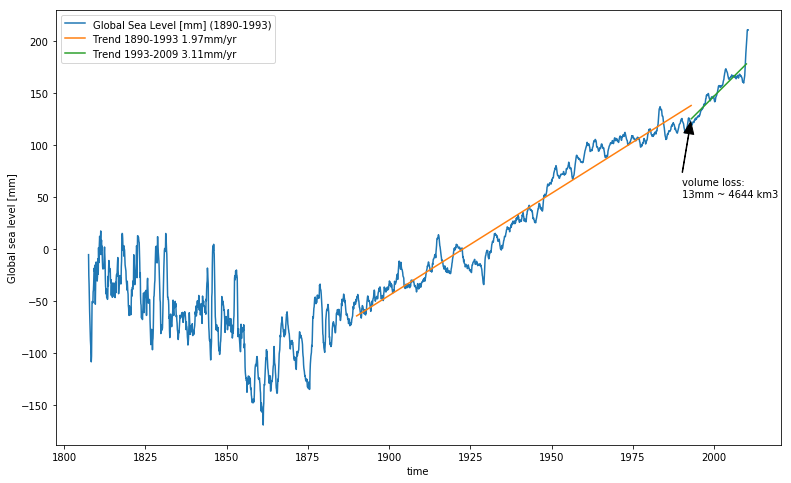

In [8]:
# now plot the trends of Jevrejeva 2014

before_sl = before_fit.predict([1, 1993-1970])[0]
after_sl = after_fit.predict([1, 1993-1970])[0]
fig, ax = plt.subplots(figsize=(13, 8), sharex=True)
ax.plot(df.index, df['gsl [mm]'], label='Global Sea Level [mm] (1890-1993)')
ax.plot(before_fit.model.exog[:, 1] + 1970, before_fit.predict(), label='Trend 1890-1993 {:.2f}mm/yr'.format(before_fit.params[1]))
ax.plot(after_fit.model.exog[:, 1] + 1970, after_fit.predict(), label='Trend 1993-2009 {:.2f}mm/yr'.format(after_fit.params[1]))
ax.set_xlabel('time')
ax.set_ylabel('Global sea level [mm]')
ax.legend(loc='best')
sl_loss = - (after_sl - before_sl) * ureg.millimeter
ocean_area = 360_000_000 * (ureg.kilometer**2)
vol_loss = (sl_loss * ocean_area).to(ureg.kilometer**3)

ax.annotate(
    'volume loss:\n{:.0f}mm ~ {:.0f} km3'.format(- (after_sl - before_sl), vol_loss.magnitude), 
    xy=(1993, after_sl), 
    xytext=(1990, 50),
    arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=10)
)

fig.savefig('non-conservative-jevrejeva2014.pdf')


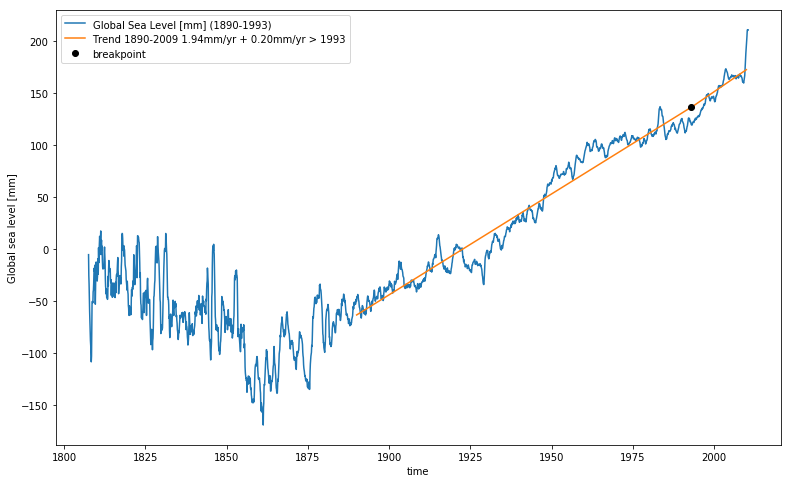

In [9]:
# Assuming there is a continuouity in water, it is better to use a broken linear trend model. 
break_fit, break_names = linear_model(df[np.logical_and(df.index >= 1890, df.index < 2010)], with_break=True)

fig, ax = plt.subplots(figsize=(13, 8))
ax.plot(df.index, df['gsl [mm]'], label='Global Sea Level [mm] (1890-1993)')
ax.plot(break_fit.model.exog[:, 1] + 1970, break_fit.predict(), label='Trend 1890-2009 {:.2f}mm/yr + {:.2f}mm/yr > 1993'.format(
    break_fit.params[1],
    break_fit.params[2]
))

ax.plot([1993], [break_fit.predict([[1, 1993-1970, 0]])], 'ko', label='breakpoint')
ax.set_xlabel('time')
ax.set_ylabel('Global sea level [mm]')
ax.legend(loc='best')


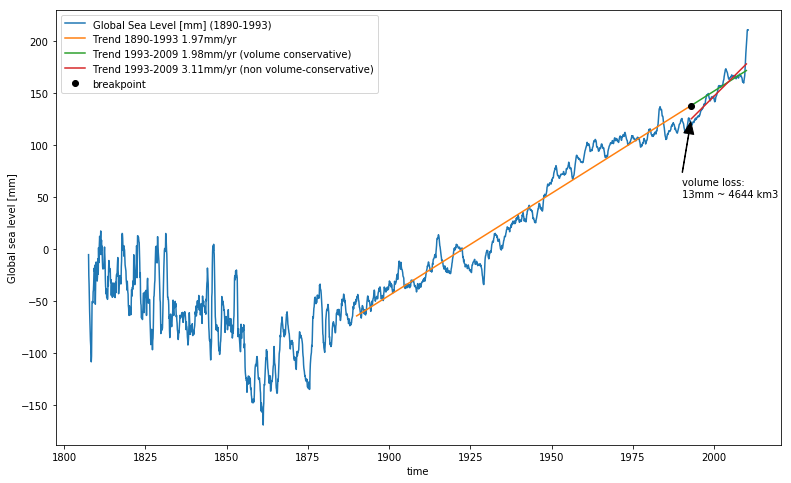

In [10]:
# Or just compute up to the satellite era and the continue from there (model without a constant) 
fixed_constant = before_fit.predict()[-1]
after_1993 = df[np.logical_and(df.index >= 1993, df.index < 2010)].copy()
after_1993.index = after_1993.index.values - 1993
after_1993['gsl [mm]'] = after_1993['gsl [mm]'] - fixed_constant
# don't add a constant
after_1993_fit = sm.OLS(after_1993['gsl [mm]'], np.c_[after_1993.index.values]).fit()


fig, ax = plt.subplots(figsize=(13, 8))
ax.plot(df.index, df['gsl [mm]'], label='Global Sea Level [mm] (1890-1993)')
ax.plot(before_fit.model.exog[:, 1] + 1970, before_fit.predict(), label='Trend 1890-1993 {:.2f}mm/yr'.format(before_fit.params[1]))
ax.plot(after_1993.index.values + 1993, after_1993_fit.predict() + fixed_constant, label='Trend 1993-2009 {:.2f}mm/yr (volume conservative)'.format(after_1993_fit.params[0]))
ax.plot(after_fit.model.exog[:, 1] + 1970, after_fit.predict(), label='Trend 1993-2009 {:.2f}mm/yr (non volume-conservative)'.format(after_fit.params[1]))

ax.plot([1993], [fixed_constant], 'ko', label='breakpoint')
ax.annotate(
    'volume loss:\n{:.0f}mm ~ {:.0f} km3'.format(- (after_sl - before_sl), 4644), 
    xy=(1993, after_sl), 
    xytext=(1990, 50),
    arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=10)
)

ax.set_xlabel('time')
ax.set_ylabel('Global sea level [mm]')
ax.legend(loc='best')
fig.savefig('conservative-jevrejeva.pdf')

